# Optimizer - spectrum

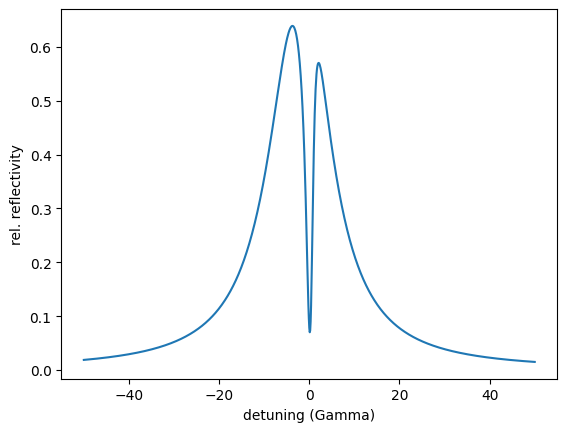

In [1]:
import nexus as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

data = np.loadtxt('reference_spectrum.txt')

detuning_reference = data[:,0]
intensity_reference = data[:,1]

plt.plot(detuning_reference, intensity_reference)
plt.xlabel('detuning (Gamma)')
plt.ylabel('rel. reflectivity')
plt.show()

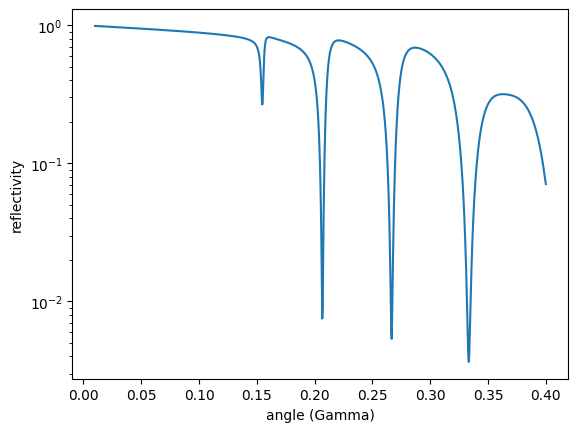

In [2]:
# ------------------------- layers --------------------------
lay_Fe_top = nx.Layer(id = "Fe top",
                  material = nx.Material.Template(nx.lib.material.Fe_enriched),
                  thickness = 1)

lay_Fe_bottom = nx.Layer(id = "Fe bottom",
                  material = nx.Material.Template(nx.lib.material.Fe_enriched),
                  thickness = 1)

site = nx.Hyperfine(id = "no interactions")

lay_Fe_top.material.hyperfine_sites = [site]

lay_Fe_bottom.material.hyperfine_sites = [site]


lay_B4C_top = nx.Layer(id = "B4C top",
                   material = nx.Material.Template(nx.lib.material.B4C),
                   thickness = nx.Var(value = 4, min = 0, max = 10, fit = True, id = "B4C top"))

lay_B4C_mid = nx.Layer(id = "B4C mid",
                   material = nx.Material.Template(nx.lib.material.B4C),
                   thickness = nx.Var(value = 4, min = 0, max = 10, fit = True, id = "B4C mid"))

lay_B4C_bottom = nx.Layer(id = "B4C bottom",
                   material = nx.Material.Template(nx.lib.material.B4C),
                   thickness = nx.Var(value = 16, min = 0, max = 20, fit = True, id = "B4C top"))

# the initial guess for the top layer is 3 nm here
# set it to a Var object with reasonable bounds
lay_Pt_top = nx.Layer(id = "Pt top",
                      material = nx.Material.Template(nx.lib.material.Pt),
                      thickness = nx.Var(3.2, min = 0, max = 10, fit = True, id = "Pt top thickness"))

lay_Pt_bottom = nx.Layer(id = "Pt bottom",
                         material = nx.Material.Template(nx.lib.material.Pt),
                         thickness = 15)


lay_substrate = nx.Layer(id = "substrate",
                         material = nx.Material.Template(nx.lib.material.Si),
                         thickness = nx.inf)

cavity = nx.Sample(id = "cavity",
                   geometry = "r",
                   layers = [lay_Pt_top,
                             lay_B4C_top,
                             lay_Fe_top,
                             lay_B4C_mid,
                             lay_Fe_bottom,
                             lay_B4C_bottom,
                             lay_Pt_bottom,
                             lay_substrate],
                   angle = 0.1505)

beam  = nx.Beam()
beam.LinearSigma()

exp = nx.Experiment(beam = beam,
                    objects = cavity,
                    isotope = nx.lib.moessbauer.Fe57,
                    id = "my exp")

# initialize a reflectivity object used for the optimization
angles = np.linspace(0.01, 0.4, 1001)

reflectivity = nx.Reflectivity(experiment = exp,
                               sample = cavity,
                               energy = nx.lib.energy.Fe57,
                               angles = angles)

intensity = reflectivity()

# third minimum
min_index = np.squeeze(argrelextrema(intensity, np.less))[2]

cavity.angle = angles[min_index]

plt.semilogy(angles, intensity)
plt.xlabel('angle (Gamma)')
plt.ylabel('reflectivity')
plt.show()

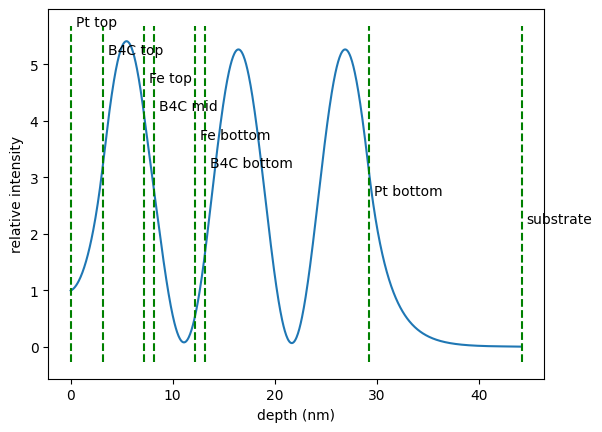

In [3]:
field_int = nx.FieldIntensity(sample = cavity,
                              energy = nx.moessbauer.Fe57.energy,
                              points = 1001)

depth, int = field_int()

plt.plot(depth, int)

# add lines and labels
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.vlines(cavity.Interfaces(), y_min, y_max, colors='g', linestyles='dashed')
for id, location in zip(cavity.Ids(), np.array(cavity.Interfaces()) + 0.5):
    plt.text(location, y_max, id, fontsize = 10)
    y_max = y_max - 0.5

plt.xlabel('depth (nm)')
plt.ylabel('relative intensity')
plt.show()

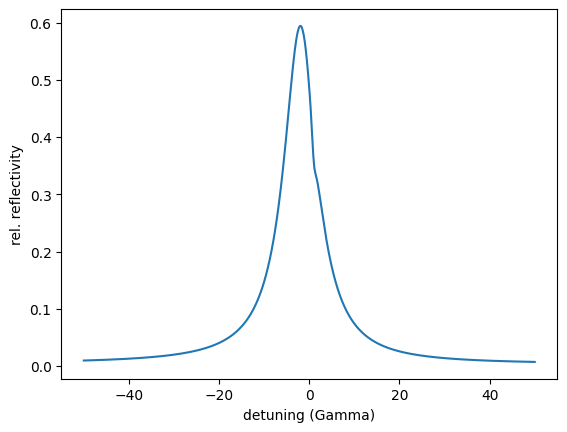

In [4]:
energy_spectrum = nx.EnergySpectrum(experiment = exp,
                                    detuning = detuning_reference,
                                    electronic = True,
                                    id = "my energy spectrum")

intensity = energy_spectrum.Calculate()

plt.plot(detuning_reference, intensity)
plt.xlabel('detuning (Gamma)')
plt.ylabel('rel. reflectivity')
plt.show()


Run Optimizer instance with id: opt id 

Starting optimizer with 2 provided measurement dependencies and 4 fit parameter(s):

  no. |                           id |       initial value |              min |              max
    0 |             Pt top thickness |                 3.2 |                0 |               10
    1 |                      B4C top |                   4 |                0 |               10
    2 |                      B4C mid |                   4 |                0 |               10
    3 |                      B4C top |                  16 |                0 |               20

Using 0 equality constraint(s) on parameter(s):

Using 0 inequality constraint(s).

Residual start value: 12.4597


Calling ceres solver with fit method LevMar

Ceres Solver Report: Iterations: 4, Initial cost: 7.762264e+01, Final cost: 1.070671e+01, Termination: CONVERGENCE

Optimizer finished with 4 fit parameter(s):

  no. |                           id |           fit value |     

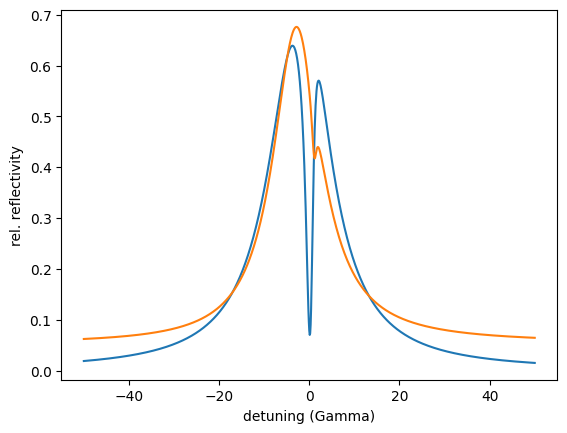

In [5]:
# setup the optimizer
class NexusOptimizer(nx.Optimizer):
    def __init__(self, measurements, id):
        super().__init__(measurements, id)

    # the defienition of the residual calculation
    def Residual(self):
        # calculate the reflectivity to find the third minimum
        ref = reflectivity()
        # get the index of the third minimum
        # in case threre is no third minimum due to the combination of thicknesses
        if (len(argrelextrema(ref, np.less)[0]) < 3):
             return 1e30
        min_index = np.squeeze(argrelextrema(ref, np.less))[2]
        # set cavity angle to third minimum
        cavity.angle = angles[min_index]
        # calculate energy_spectrum
        intensity = energy_spectrum()
        # calculate residual
        differences = intensity - intensity_reference
        residual = np.sum(np.square(differences))
        return residual

# pass the reflectivity object to the optimizer
opt = NexusOptimizer(measurements = [reflectivity, energy_spectrum],
                     id = "opt id")

# let's just use a local gradient-free algorithm here
opt.options.method = "LevMar"

# run the optimization
opt()

plt.plot(detuning_reference, intensity_reference)
plt.plot(detuning_reference, energy_spectrum.result)
plt.xlabel('detuning (Gamma)')
plt.ylabel('rel. reflectivity')
plt.show()


Run Optimizer instance with id: opt id 

Starting optimizer with 2 provided measurement dependencies and 4 fit parameter(s):

  no. |                           id |       initial value |              min |              max
    0 |             Pt top thickness |                 3.2 |                0 |               10
    1 |                      B4C top |                   4 |                0 |               10
    2 |                      B4C mid |                   4 |                0 |               10
    3 |                      B4C top |                  16 |                0 |               20

Using 0 equality constraint(s) on parameter(s):

Using 0 inequality constraint(s).

Residual start value: 12.4597


Calling NLopt solver with fit method Subplex

Termination: parameter tolerance reached.

  cost = 1.263866e-06
  iterations: 278

Optimizer finished with 4 fit parameter(s):

  no. |                           id |           fit value |       initial value |              

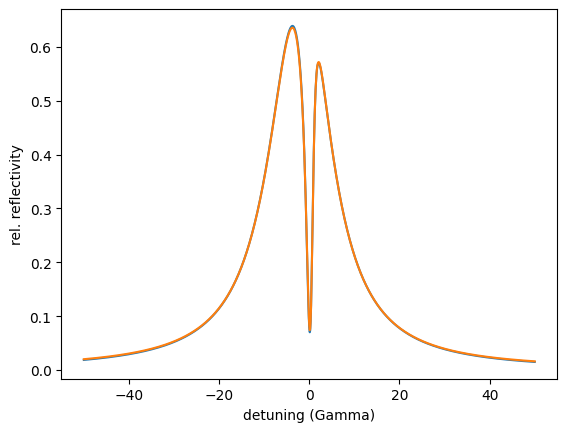

In [6]:
opt.options.method = "Subplex"

opt.SetInitialVars()

# run the optimization
opt()

plt.plot(detuning_reference, intensity_reference)
plt.plot(detuning_reference, energy_spectrum.result)
plt.xlabel('detuning (Gamma)')
plt.ylabel('rel. reflectivity')
plt.show()


Run Optimizer instance with id: opt id 

Starting optimizer with 2 provided measurement dependencies and 4 fit parameter(s):

  no. |                           id |       initial value |              min |              max
    0 |             Pt top thickness |                 3.2 |                0 |               10
    1 |                      B4C top |                   4 |                0 |               10
    2 |                      B4C mid |                   4 |                0 |               10
    3 |                      B4C top |                  16 |                0 |               20

Using 0 equality constraint(s) on parameter(s):

Using 0 inequality constraint(s).

Residual start value: 12.4597


Calling Pagmo solver with fit method PagmoDiffEvol

  population: 50
  iterations: 100

  cost = 3.822179e-06

Calling ceres solver with fit method LevMar

Ceres Solver Report: Iterations: 2, Initial cost: 3.822179e-06, Final cost: 2.776746e-06, Termination: CONVERGENCE


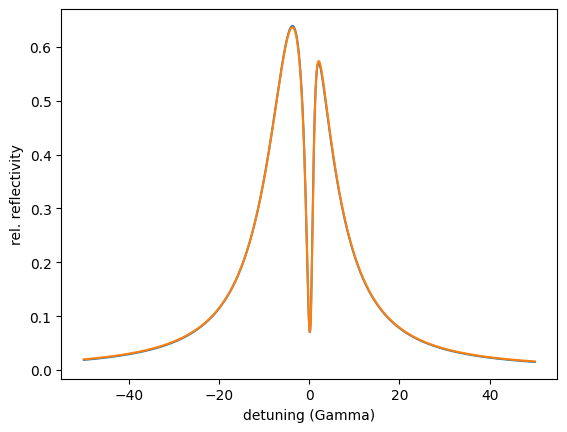

In [7]:
opt.options.method = "PagmoDiffEvol"

opt.SetInitialVars()

# run the optimization
opt()

plt.plot(detuning_reference, intensity_reference)
plt.plot(detuning_reference, energy_spectrum.result)
plt.xlabel('detuning (Gamma)')
plt.ylabel('rel. reflectivity')
plt.show()

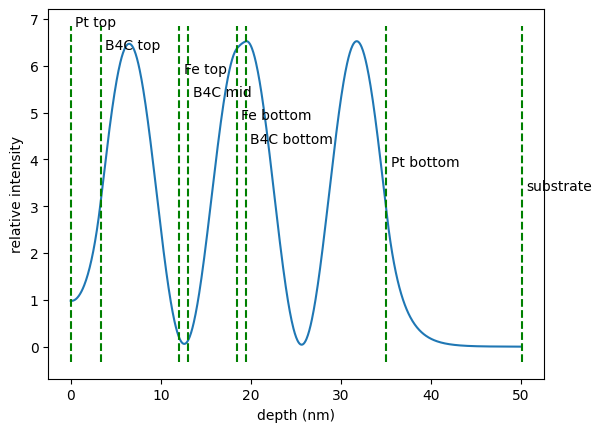

In [8]:
# calcualte field intensity inside the sample
field_int = nx.FieldIntensity(sample = cavity,
                              energy = nx.moessbauer.Fe57.energy,
                              points = 1001)

depth, int = field_int()

plt.plot(depth, int)

# add lines and labels
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.vlines(cavity.Interfaces(), y_min, y_max, colors='g', linestyles='dashed')
for id, location in zip(cavity.Ids(), np.array(cavity.Interfaces()) + 0.5):
    plt.text(location, y_max, id, fontsize = 10)
    y_max = y_max - 0.5

plt.xlabel('depth (nm)')
plt.ylabel('relative intensity')
plt.show()